## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [31]:
import os
from tensorflow import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [32]:
train, test = keras.datasets.cifar10.load_data()

In [33]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [34]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [39]:

def build_mlp(input_shape, output_units=10, num_neuron=[2048,1024,512,256,128,64],drop_ratio=0.25):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, num in enumerate(num_neuron):
        if i == 0 :
            x = keras.layers.BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=num, activation='relu')(input_layer)
            x = keras.layers.Dropout(drop_ratio)(x)
        else :
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Dense(units=num, activation='relu')(x)
            x = keras.layers.Dropout(drop_ratio)(x)
    out = keras.layers.Dense(units=output_units, activation='softmax')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [36]:
"""Code Here
設定超參數
"""
BATCH_SIZE = 256
LEARNING_RATE = [1e-3,1e-4,1e-5]
EPOCHS = 50
OPTIMIZERS = [keras.optimizers.SGD, keras.optimizers.Adam, keras.optimizers.Adagrad]

In [37]:
x_train.shape[1:]

(3072,)

In [51]:
str(opt).split(sep='.')[-1].split(sep="'")[0]

'Adagrad'

In [52]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for lr, opt in itertools.product(LEARNING_RATE,OPTIMIZERS):
    keras.backend.clear_session()
    model = build_mlp(input_shape=x_train.shape[1:])
    
    optimizer = opt(learning_rate=lr)
    model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    model.fit(x_train,y_train,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              validation_data=(x_test,y_test),
              shuffle=True)
    
    train_acc = model.history.history['accuracy']
    valid_acc = model.history.history['val_accuracy']
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    
    tag = "Optimizer=%s, Learning_rate=%s" % (str(opt).split(sep='.')[-1].split(sep="'")[0], str(lr))
    results[tag] = {'train_acc':train_acc,
                    'train_loss':train_loss,
                    'valid_acc':valid_acc,
                    'valid_loss':valid_loss}


Epoch 1/50
196/196 [==============================] - 2s 11ms/step - loss: 2.7625 - accuracy: 0.1096 - val_loss: 2.3274 - val_accuracy: 0.1334
Epoch 2/50
196/196 [==============================] - 2s 10ms/step - loss: 2.6667 - accuracy: 0.1233 - val_loss: 2.2446 - val_accuracy: 0.1634
Epoch 3/50
196/196 [==============================] - 2s 10ms/step - loss: 2.5767 - accuracy: 0.1405 - val_loss: 2.1551 - val_accuracy: 0.2117
Epoch 4/50
196/196 [==============================] - 2s 10ms/step - loss: 2.5052 - accuracy: 0.1531 - val_loss: 2.1017 - val_accuracy: 0.2423
Epoch 5/50
196/196 [==============================] - 2s 10ms/step - loss: 2.4493 - accuracy: 0.1629 - val_loss: 2.0555 - val_accuracy: 0.2609
Epoch 6/50
196/196 [==============================] - 2s 10ms/step - loss: 2.4111 - accuracy: 0.1742 - val_loss: 2.0340 - val_accuracy: 0.2687
Epoch 7/50
196/196 [==============================] - 2s 10ms/step - loss: 2.3746 - accuracy: 0.1838 - val_loss: 2.0023 - val_accuracy: 0.2808

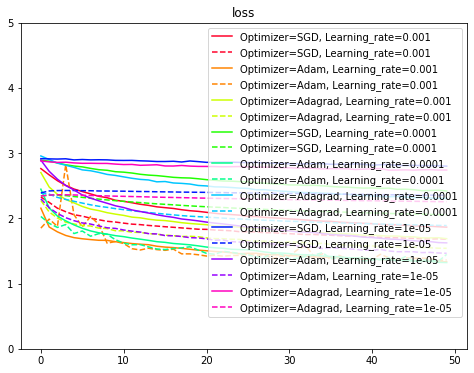

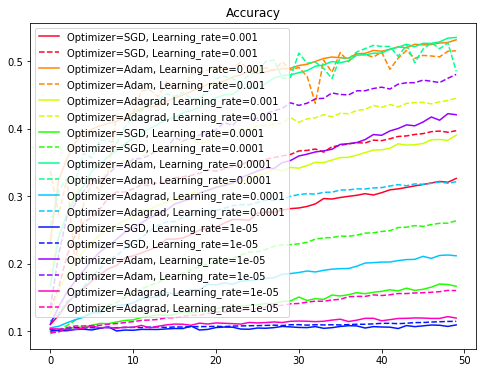

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 9

cm = plt.get_cmap('gist_rainbow')
cNorm = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'],'-',color=color_bar[i],label=cond)
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'],'--',color=color_bar[i],label=cond)
plt.ylim([0, 5])
plt.title('loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'],'-',color=color_bar[i],label=cond)
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'],'--',color=color_bar[i],label=cond)
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
import